In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jax.example_libraries.optimizers import adamax as optimizer
jax.config.update('jax_platform_name', 'cpu')
# jax.config.update('jax_disable_jit', True)

In [2]:
MB = 2 ** 10
NN_SHAPES = jnp.array([64, 64, 64])
SCALE = 0.1
INIT_KEYS = jax.random.split(jax.random.PRNGKey(1), 8)

BETA = 0.5
MAX_AGE = 2.
MIN_DP = 0.4
INTEREST = 0.5
OBJECTIVE_FN = lambda x, t: jax.lax.select(t == 2., 
                                           jnp.array([jnp.log(x), x]), 
                                           jax.lax.select(t == 1., 
                                                          jnp.array([jnp.log(x / (1 + BETA)) + BETA * jnp.log((BETA * x) / (1 + BETA)), (x / (1 + BETA))]), 
                                                          jnp.array([(1 + BETA + BETA**2) * jnp.log(x) - (1 + BETA + BETA **2) * jnp.log(1 + BETA + BETA**2) + BETA * (1 + 2 * BETA) * jnp.log(BETA),
                                                                     x / (1 + BETA + BETA**2)])))

In [3]:
w0 = SCALE * jax.random.normal(INIT_KEYS[0], shape=(3, NN_SHAPES[0]))
w1 = SCALE * jax.random.normal(INIT_KEYS[1], shape=(NN_SHAPES[0], NN_SHAPES[1]))
w2 = SCALE * jax.random.normal(INIT_KEYS[2], shape=(NN_SHAPES[1] + 3, NN_SHAPES[2]))
wf = SCALE * jax.random.normal(INIT_KEYS[3], shape=(NN_SHAPES[2],))
b0 = SCALE * jax.random.normal(INIT_KEYS[4], shape=(1, NN_SHAPES[0]))
b1 = SCALE * jax.random.normal(INIT_KEYS[5], shape=(1, NN_SHAPES[1]))
b2 = SCALE * jax.random.normal(INIT_KEYS[6], shape=(1, NN_SHAPES[2]))
bf = SCALE * jax.random.normal(INIT_KEYS[7], shape=(1,))
params0 = {'w0': w0, 'w1': w1, 'vw2': w2, 'cw2': w2, 'vwf': wf, 'cwf': wf, 
           'b0': b0, 'b1': b1, 'vb2': b2, 'cb2': b2, 'vbf': bf, 'cbf': bf}

In [4]:
@jax.jit
def linear(X, w, b):
    return jnp.dot(X, w) + b


@jax.jit
def relu(X, w, b):
    return jnp.maximum(linear(X, w, b), 0)


@jax.jit
def neural_network(params, x, t, o):
    x += o * INTEREST * x # If the agent is an owner, collect interest on savings
    
    l0 = jnp.concatenate((x[jnp.newaxis], t[jnp.newaxis], o[jnp.newaxis]))
    l1 = relu(l0, params['w0'], params['b0'])
    l2 = jnp.squeeze(relu(l1, params['w1'], params['b1']))
    
    vl3 = relu(jnp.concatenate((l0, l2)), params['vw2'], params['vb2'])
    vu = linear(vl3, params['vwf'], params['vbf'])
    v = jnp.select(t[jnp.newaxis] > MAX_AGE, jnp.zeros(1), vu)
    
    cl3 = relu(jnp.concatenate((l0, l2)), params['cw2'], params['cb2'])
    cu = x * jax.nn.tanh(linear(cl3, params['cwf'], params['cbf']) / 1000)
    c = jnp.select(t[jnp.newaxis] >= MAX_AGE, x[jnp.newaxis], cu)
    
    o1 = jnp.minimum(o + jnp.int32(x - c >= MIN_DP), 1.) # If the agent saves enough they can become an owner
    return jnp.concatenate((v, c, x - c, o1))


@jax.jit
def loss(params, x, t, o):
    v0, c0, x1, o1 = neural_network(params, x, t, o)
    v1, c1, x2, o2 = neural_network(params, x1, t + 1, o1)
    
    vf = lambda params, x, t, o: neural_network(params, x, t, o)[0]
    v1r = vf(params, x1, t + 1, 0.)
    v1o = vf(params, x1, t + 1, 1.)
    v_diff = v1o - v1r
    v1x = jax.grad(vf, (1))(params, x1, t + 1, o1)
    
    live_next = (t < MAX_AGE)
    loss_euler = jax.lax.select(live_next, 
                                jax.lax.select(o == 1.,
                                               1e2 * (c1 - ((BETA * (1 + INTEREST)) * c0)),
                                               jax.lax.select(x1 >= MIN_DP,
                                                              0.,
                                                              # (BETA * c0 * (v1x + (v_diff / (MIN_DP - x1))) - 1))),
                                                              c1 - BETA * c0 * (1 + jnp.int32(jnp.isclose(x1, MIN_DP)) * v_diff * c1))), 
                                                              # (c1 - BETA) * c0 + jnp.maximum(0, v_diff - (MIN_DP - x1) / c0))),
                                0.)
    loss_bellman = (jnp.log(c0) + BETA * v1) - v0
    loss_value = jnp.log(c0) + v1
    loss_jump = 0 # jax.lax.select(jnp.logical_and((o == 0.), (x1 >= MIN_DP)), 1., 0.)
    
    return jnp.array([10 * loss_euler, loss_bellman, 1e-2 * loss_value, 1e5 * loss_jump])


@jax.jit
def batch_loss(params, xs, ts, os):
    losses = jax.vmap(loss, in_axes=(None, 0, 0, 0))(params, xs, ts, os)
    return jnp.mean(losses[:, 0]**2 + losses[:, 1]**2 - losses[:, 2] - losses[:, 3])

In [5]:
def training_loop(X, T, O, opt_state, opt_update, get_params, max_iter=1000):
    j = 0
    key = jax.random.PRNGKey(1)
    keys = jax.random.split(key, max_iter)

    while j < max_iter:
        key = keys[j]
        sample = jax.random.choice(key, jnp.arange(X.shape[0]), (3, MB))

        val_loss, grad = jax.value_and_grad(batch_loss)(get_params(opt_state), X[sample[0]], T[sample[1]], O[sample[2]])
        opt_state = opt_update(j, grad, opt_state)
        j += 1
        if j % 100 == 0:
            print(f'Iteration: {j}\tLoss: {val_loss}')
            
    return opt_state

In [6]:
opt_init, opt_update, get_params = optimizer(step_size=1e-1)
opt_state = opt_init(params0)
X = jnp.linspace(1e-5, 1., 1000)
T = jnp.concatenate((jnp.zeros(333), jnp.ones(333), 2 * jnp.ones(334)))
O = jnp.concatenate((jnp.zeros(500), jnp.ones(500)))

opt_state = training_loop(X, T, O, opt_state, opt_update, get_params, max_iter=1000)

Iteration: 100	Loss: 290.98046875
Iteration: 200	Loss: 31.76508331298828
Iteration: 300	Loss: 2.653053045272827
Iteration: 400	Loss: 1.070313811302185
Iteration: 500	Loss: 0.7555191516876221
Iteration: 600	Loss: 0.7458420395851135
Iteration: 700	Loss: 0.5410735607147217
Iteration: 800	Loss: 0.5550552010536194
Iteration: 900	Loss: 0.638648509979248
Iteration: 1000	Loss: 0.633918285369873


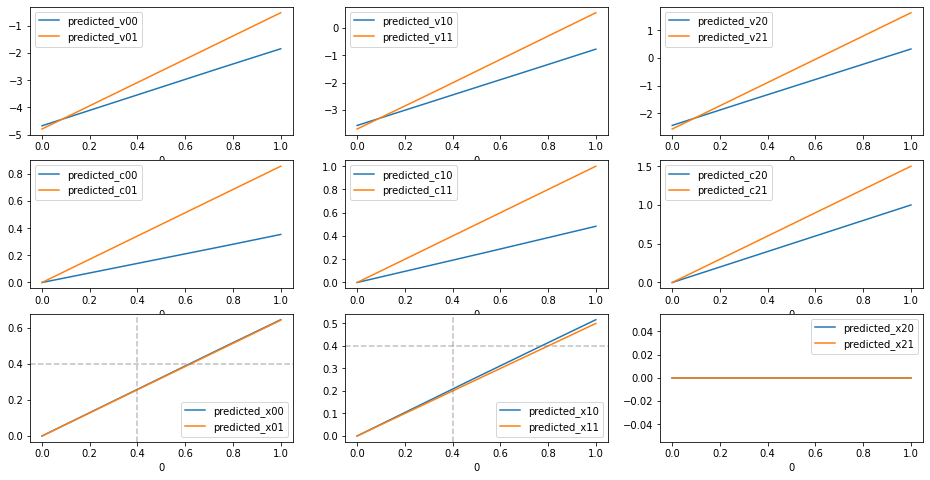

In [7]:
params = get_params(opt_state)

init00 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 0., 0.)
pred00 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 0., 0.)

init10 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 1., 0.)
pred10 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 1., 0.)

init20 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 2., 0.)
pred20 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 2., 0.)

init01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 0., 1.)
pred01 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 0., 1.)

init11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 1., 1.)
pred11 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 1., 1.)

init21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params0, X, 2., 1.)
pred21 = jax.vmap(neural_network, in_axes=(None, 0, None, None))(params, X, 2., 1.)

df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), 
                                   init00, pred00, init10, pred10, init20, pred20,
                                   init01, pred01, init11, pred11, init21, pred21), 
                                  axis=1)).set_index(0)
df.columns = ['initial_v00', 'initial_c00', 'initial_x00', 'initial_o10', 'predicted_v00', 'predicted_c00', 'predicted_x00', 'predicted_o10',
              'initial_v10', 'initial_c10', 'initial_x10', 'initial_o20', 'predicted_v10', 'predicted_c10', 'predicted_x10', 'predicted_o20', 
              'initial_v20', 'initial_c20', 'initial_x20', 'initial_o30', 'predicted_v20', 'predicted_c20', 'predicted_x20', 'predicted_o30',
              'initial_v01', 'initial_c01', 'initial_x00', 'initial_o11', 'predicted_v01', 'predicted_c01', 'predicted_x01', 'predicted_o11',
              'initial_v11', 'initial_c11', 'initial_x11', 'initial_o21', 'predicted_v11', 'predicted_c11', 'predicted_x11', 'predicted_o21', 
              'initial_v21', 'initial_c21', 'initial_x21', 'initial_o31', 'predicted_v21', 'predicted_c21', 'predicted_x21', 'predicted_o31']

fig, axes = plt.subplots(3, 3, figsize=(16, 8))
df.plot(y=['predicted_v00'], ax=axes.flatten()[0])
df.plot(y=['predicted_v10'], ax=axes.flatten()[1])
df.plot(y=['predicted_v20'], ax=axes.flatten()[2])
df.plot(y=['predicted_v01'], ax=axes.flatten()[0])
df.plot(y=['predicted_v11'], ax=axes.flatten()[1])
df.plot(y=['predicted_v21'], ax=axes.flatten()[2])
df.plot(y=['predicted_c00'], ax=axes.flatten()[3])
df.plot(y=['predicted_c10'], ax=axes.flatten()[4])
df.plot(y=['predicted_c20'], ax=axes.flatten()[5])
df.plot(y=['predicted_c01'], ax=axes.flatten()[3])
df.plot(y=['predicted_c11'], ax=axes.flatten()[4])
df.plot(y=['predicted_c21'], ax=axes.flatten()[5])
df.plot(y=['predicted_x00'], ax=axes.flatten()[6])
df.plot(y=['predicted_x10'], ax=axes.flatten()[7])
df.plot(y=['predicted_x20'], ax=axes.flatten()[8])
df.plot(y=['predicted_x01'], ax=axes.flatten()[6])
df.plot(y=['predicted_x11'], ax=axes.flatten()[7])
df.plot(y=['predicted_x21'], ax=axes.flatten()[8])
for ax in axes.flatten()[6:8]:
    ax.axhline(y=MIN_DP, color='grey', linestyle='--', alpha=0.5)
    ax.axvline(x=MIN_DP, color='grey', linestyle='--', alpha=0.5)

We should see that once starting wealth (x-axis) is above 0.4, it is possible for the renter to try and become a homeowner, so the savings function (x_00) should bend up to the horizontal grey line. Instead we see it stays completely linear, the renter is indifferent to becoming a homeowner, even though we have estimated correctly that the homeowner has a higher value.

In [8]:
all_X = jnp.concatenate((jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000),
                        jnp.linspace(1e-5, 1., 1000), jnp.linspace(1e-5, 1., 1000)))
all_T = jnp.concatenate((jnp.zeros(1000), jnp.ones(1000), jnp.zeros(1000), jnp.ones(1000)))
all_O = jnp.concatenate((jnp.zeros(1000), jnp.zeros(1000), jnp.ones(1000), jnp.ones(1000)))

In [9]:
batch_loss(params, all_X[0:1000], all_T[0:1000], all_O[0:1000])

DeviceArray(0.66560477, dtype=float32)

In [10]:
batch_loss(params, all_X[1000:2000], all_T[1000:2000], all_O[1000:2000])

DeviceArray(1.7774001, dtype=float32)

In [11]:
batch_loss(params, all_X[2000:3000], all_T[2000:3000], all_O[2000:3000])

DeviceArray(0.45451757, dtype=float32)

In [12]:
batch_loss(params, all_X[3000:4000], all_T[3000:4000], all_O[3000:4000])

DeviceArray(0.3795389, dtype=float32)